# FIRST CONFIGURATION

first i will configure the env and mount my google drive folder to save files in case of crash.


1. Then we'll have training of model
2. attacking with FGSM
3. adversarial training




In [1]:
from google.colab import drive
drive.mount('/content/gdrive/') 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd /content/gdrive/My\ Drive/ColabFiles/chapter10

/content/gdrive/My Drive/ColabFiles/chapter10


In [3]:
!sudo apt-get install git
!git clone https://github.com/katywarr/strengthening-dnns.git .

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
fatal: destination path '.' already exists and is not an empty directory.


In [4]:
ls

fashionMNIST_adversarial_training_evaluation.ipynb
fashionMNIST_adversarial_training.ipynb
fashionMNIST_dropout_adversarial_generation.ipynb
fashionMNIST_dropout_for_detection.ipynb


In [5]:
!cat ../requirements.txt | grep tensor

tensorboard=1.13.1=py37h33f27b4_0
tensorflow=1.13.1=mkl_py37h9463c59_0
tensorflow-base=1.13.1=mkl_py37hcaf7020_0
tensorflow-estimator=1.13.0=py_0


In [6]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [7]:
!pip install foolbox==1.8.0

In [8]:
cd ./chapter10/

[Errno 2] No such file or directory: './chapter10/'
/content/gdrive/My Drive/ColabFiles/chapter10


# Training a Model With Adversarial Data
This notebook accompanies the adversarial training evaluation code in chapter10/FashionMNIST_adversarial_training_evaluation.ipynb.

It augments the Fashion-MNIST training set with adversarial data and uses this broader training set to train a classifier. You can then save the adversarially-trained model for evaluation.

An adversarially trained model fashionMNIST_advtrain_fastgradient.h5 (using training data generated with the foolbox.attacks.GradientSignAttack) is also available in the models folder of this repository if you don't want to do the training yourself.

# Import everything that we need


In [9]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('../models/fashionMNIST.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Helper methods for generating adversarial data and plotting images and their adversarial labels. We'll use these later.

In [0]:
def plot_sample_images(model, images, expected_labels):
    predictions = model.predict(images)
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions[i])
        if predicted_label == expected_labels[i]:
            color = 'blue'
        else:
            color = 'red'
        
        plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[expected_labels[i]]),
                                color=color)   

# Import helper function
import sys
sys.path.append('..')
from strengtheningdnns.adversarial_utils import generate_adversarial_data

# Load in the existing (non-adversarially trained) model

We'll use this to generate adversarial examples for training


In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = train_images/255.0
test_images = test_images/255.0

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Model accuracy based on test data:', test_acc)

10000/10000 [==============================] - 1s 72us/sample - loss: 0.3623 - acc: 0.8704
Model accuracy based on test data: 0.8704


In [13]:
import foolbox
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)
#attack_fn = foolbox.attacks.SaliencyMapAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.L0)

In [14]:

x_images = train_images[0:6000, :]
(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = \
generate_adversarial_data(original_images = x_images, predictions = model.predict(x_images), attack_fn = attack_fn)

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [0]:
train_images_plus_adv = np.concatenate((train_images, x_train_adv_images), axis=0)
train_labels_plus_adv = np.concatenate((train_labels, x_train_labels), axis=0)

In [0]:
def generate_model(input_shape, class_names, last_layer_type='softmax',loss='sparse_categorical_crossentropy',):
  temp_model = keras.Sequential([keras.layers.Flatten(input_shape=input_shape),
                            keras.layers.Dense(56, activation='relu'),
                            keras.layers.Dense(56, activation='relu'),
                            keras.layers.Dense(10, activation=last_layer_type, name='predictions_layer')
                          ])
  temp_model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=loss,
                metrics=['accuracy'])
  return temp_model


In [17]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
model_adv = generate_model((28,28),class_names)
print(model.summary())
model_adv.fit(train_images_plus_adv, train_labels_plus_adv, epochs=6)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 56)                43960     
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3192      
_________________________________________________________________
predictions_layer (Dense)    (None, 10)                570       
Total params: 47,722
Trainable params: 47,722
Non-trainable params: 0
_________________________________________________________________
None
Train on 65984 samples
Epoch 1/6
65984/65984 [==============================] - 4s 60us/sample - loss: 0.5143 - acc: 0.8191
Epoch 2/6
65984/65984 [==============================] - 4s 60us/sample - loss: 0.3802 - acc: 0.8625
Epoch 3/6
65984/6598

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Original model accuracy based on non-adversarial test data:', test_acc)
test_loss, test_acc = model_adv.evaluate(test_images, test_labels)
print('Adversarially trained model accuracy based on non-adversarial test data:', test_acc)

10000/10000 [==============================] - 0s 41us/sample - loss: 0.3623 - acc: 0.8704
Original model accuracy based on non-adversarial test data: 0.8704
10000/10000 [==============================] - 0s 45us/sample - loss: 0.3455 - acc: 0.8774
Adversarially trained model accuracy based on non-adversarial test data: 0.8774


In [0]:
x_images = test_images[0:10, :]
(x_test_adv_images, x_test_adv_perturbs, x_test_labels) = \
generate_adversarial_data(original_images = x_images, predictions = model.predict(x_images), attack_fn = attack_fn)

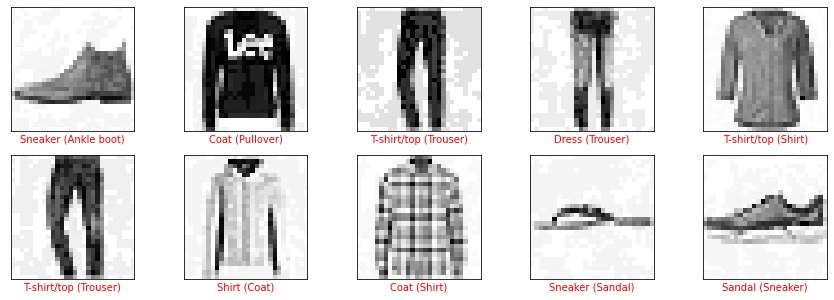

In [20]:
plot_sample_images(model, x_test_adv_images, x_test_labels)


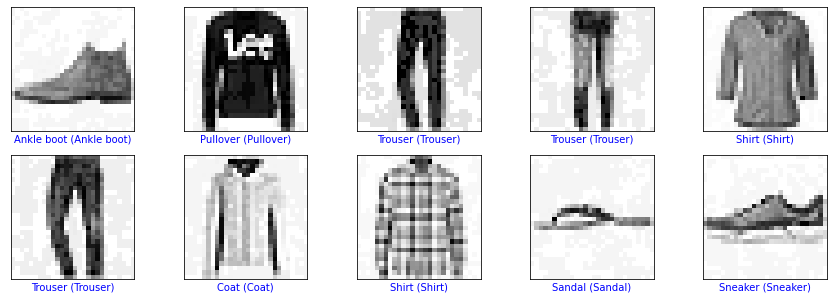

In [21]:
plot_sample_images(model_adv, x_test_adv_images, x_test_labels)


# Network distillation





Here we have two networks the student and teacher so that the student network is less susceptible to adversarial attacks




In [22]:
model_adv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 56)                43960     
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3192      
_________________________________________________________________
predictions_layer (Dense)    (None, 10)                570       
Total params: 47,722
Trainable params: 47,722
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_student = generate_model((28,28), class_names,'relu',loss='logcosh')
print(model_student.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                43960     
_________________________________________________________________
dense_3 (Dense)              (None, 56)                3192      
_________________________________________________________________
predictions_layer (Dense)    (None, 10)                570       
Total params: 47,722
Trainable params: 47,722
Non-trainable params: 0
_________________________________________________________________
None


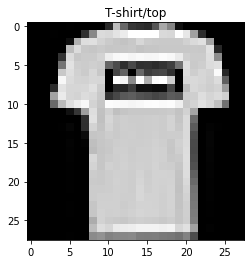

In [24]:
fig = plt.figure()
pic_index = 1
name = class_names[train_labels[pic_index]]
plt.title(name)
plt.imshow(train_images[pic_index],cmap='gray')
plt.show()

pic_predictions = model_adv.predict(np.array([train_images[pic_index]]))


In [0]:
student_training_images = train_images
student_testing_images = test_images
student_training_labels = model_adv.predict(train_images)
student_testing_labels = model_adv.predict(test_images)

In [26]:
model_student.fit(student_training_images, student_training_labels, epochs=12)

Train on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0094 - acc: 0.7795
Epoch 2/12
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0060 - acc: 0.8374
Epoch 3/12
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0056 - acc: 0.8485
Epoch 4/12
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0054 - acc: 0.8518
Epoch 5/12
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0052 - acc: 0.8561
Epoch 6/12
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0051 - acc: 0.8591
Epoch 7/12
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0050 - acc: 0.8605
Epoch 8/12
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0050 - acc: 0.8627
Epoch 9/12
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0049 - acc: 0.8645
Epoch 10/12
60000/60000 [==============================] - 

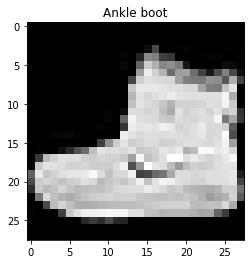

[[5.0015037e-10 6.7430790e-11 5.0215857e-14 3.4484111e-15 1.2353813e-13
  5.8224465e-05 3.8710351e-11 2.2483720e-03 1.1029478e-08 9.9769336e-01]]
[[0.        0.        0.        0.        0.        0.        0.
  0.        0.        1.0392389]]


In [27]:
fig = plt.figure()
pic_index = 0
name = class_names[train_labels[pic_index]]
plt.title(name)
plt.imshow(train_images[pic_index],cmap='gray')
plt.show()

model_adv_pic_predictions = model_adv.predict(np.array([train_images[pic_index]]))
student_pic_predictions = model_student.predict(np.array([train_images[pic_index]]))
print(*[model_adv_pic_predictions, student_pic_predictions],sep='\n')

In [28]:
temp_tests_images, temp_tests_labels = test_images,test_labels
print(temp_tests_images.shape, temp_tests_labels.shape)
print(temp_tests_labels[0])
test_loss, test_acc = model_adv.evaluate(temp_tests_images, temp_tests_labels)
print('Adversarially trained model accuracy based on non-adversarial test data:', test_acc)

def get_ones(z):
  res = np.zeros(10)
  res[z] = 1
  return res
temp_tests_labels = np.array(list(map(lambda x: get_ones(x),temp_tests_labels)))
print(temp_tests_labels[0])
test_loss, test_acc = model_student.evaluate(temp_tests_images, temp_tests_labels)
print('Student model accuracy based on non-adversarial test data:', test_acc)



(10000, 28, 28) (10000,)
9
10000/10000 [==============================] - 0s 41us/sample - loss: 0.3455 - acc: 0.8774
Adversarially trained model accuracy based on non-adversarial test data: 0.8774
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
10000/10000 [==============================] - 0s 45us/sample - loss: 0.0128 - acc: 0.7757
Student model accuracy based on non-adversarial test data: 0.7757


# Test on adversarial example

Since we didnt use x_train_adv_images lets test on these images 


Then we will test on adv_test images see if that makes sense.

In [29]:

temp_tests_labels = np.array(list(map(lambda x: get_ones(x),x_train_labels)))
print(temp_tests_labels[0])
test_loss, test_acc = model_student.evaluate(x_train_adv_images, temp_tests_labels)
print('Student model accuracy based on non-adversarial test data:', test_acc)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5984/5984 [==============================] - 0s 42us/sample - loss: 0.0170 - acc: 0.7301
Student model accuracy based on non-adversarial test data: 0.7301136


# Adversarial examples failed 

we can see that the adversarial examples failed on the student network


lets try to attack the student network assuming the attacker has an access to the student network.

You can see below that the student network is more robust against attacks because of gradient masking or smoothing so that the attack that uses gradient is very hard to generate the adversarial example. (on the original model we had only 16 warnings (unable to find adversarial example but now we have much more lets check the accuracy of student model on adversarial examples)

In [35]:

fmodel = foolbox.models.TensorFlowModel.from_keras(model_student, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)


x_images = train_images[0:1000, :]
(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = \
generate_adversarial_data(original_images = x_images, predictions = model_student.predict(x_images), attack_fn = attack_fn)

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


# accuracy of teacher on adversarial examples was 0.2 % it means the adversary had an accuracy of 99.8%. lets check the student model:



In [36]:
# (x_train_adv_images, x_train_adv_perturbs, x_train_labels) =
print(x_train_adv_images.shape, x_train_labels.shape)

(881, 28, 28) (881,)


In [39]:
_,test_acc = model_student.evaluate(x_train_adv_images,x_train_labels)
print('Student model accuracy based on adversarial test data:', test_acc)

881/881 [==============================] - 0s 51us/sample - loss: 3.3229 - acc: 0.1680
Student model accuracy based on adversarial test data: 0.16799092


# 16% is much better than 0.2 %

=================================================

# CNN and attacks and defenses



lets try CNN




In [195]:

input_shape = (28, 28)
last_layer_type = 'softmax'
model_cnn = keras.Sequential([
            
                            tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(28,28,1)),
                            tf.keras.layers.MaxPool2D((2,2)),
                            tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
                            tf.keras.layers.MaxPool2D((2,2)),

                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100,activation='relu'),
                            tf.keras.layers.Dense(100,activation='relu'),
                            tf.keras.layers.Dense(10,activation='softmax',name='prediction_layer')
            ])
            

model_cnn.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 10)        910       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 250)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_31 (Dense)             (None, 100)             

In [0]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [197]:

train_images = train_images.reshape((len(train_images),28,28,1))
print(train_images.shape)
model_cnn.fit(train_images, train_labels,epochs=20)

(60000, 28, 28, 1)
Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 94us/sample - loss: 0.5469 - acc: 0.7973
Epoch 2/20
60000/60000 [==============================] - 5s 86us/sample - loss: 0.3735 - acc: 0.8626
Epoch 3/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.3289 - acc: 0.8787
Epoch 4/20
60000/60000 [==============================] - 5s 83us/sample - loss: 0.2997 - acc: 0.8884
Epoch 5/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2787 - acc: 0.8960
Epoch 6/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2630 - acc: 0.9024
Epoch 7/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2496 - acc: 0.9068
Epoch 8/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2379 - acc: 0.9097
Epoch 9/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2262 - acc: 0.9151
Epoch 10/20
60000/60000 [===============

In [84]:
test_images = test_images.reshape((len(test_images), 28,28,1))
_,test_acc = model_cnn.evaluate(test_images,test_labels)
print('CNN model accuracy based on non-adversarial test data:', test_acc)

10000/10000 [==============================] - 1s 53us/sample - loss: 0.3368 - acc: 0.8991
CNN model accuracy based on non-adversarial test data: 0.8991


# Adversarial Attacks


Lets now try to attack the model



In [0]:
import foolbox
from foolbox import attacks

import numpy as np
from numpy import linalg as LA
def generate_adversarial_data(original_images,
                              predictions,
                              attack_fn,
                              verbose = False):

    """
    Generates adversarial data based on a specific FoolBos attack
    Args:
        original_images: The original images from which to generate the data.
        predictions: The original image predictions
        attack_fn: The required adversarial attack function
    Returns:
        A `numpy` array of the generated adversarial objects
        A `numpy' array of perturbation metrics (dict)
        A `numpy' array of the original (non-adversarial) labels associated with the adversarial images
    Raises:
    """
    num_original_images = original_images.shape[0]
    adv_images = np.empty((0, original_images.shape[1], original_images.shape[2], original_images.shape[3]),
                          dtype=int)

    l0_norms = np.empty(0, dtype=float)
    l2_norms = np.empty(0, dtype=float)
    linf_norms = np.empty(0, dtype=float)
    foolbox_diff = np.empty(0, dtype=float)

    x_labels = np.empty(0, dtype=int)

    for x_num in range(num_original_images):

        x_adv = None
        x = original_images[x_num]
        y = np.argmax(predictions[x_num])

        x_adv = attack_fn(input_or_adv=x, label=y, unpack=False)

        if verbose:
            print("Image: ",  x_num, " Prediction: ", x_adv.adversarial_class, "(", y, ")")
        if (x_adv is not None) and (x_adv.image is not None):
            x_adv_image = x_adv.image
            adv_images = np.append(adv_images, np.expand_dims(x_adv_image, axis=0), axis=0)
            x_labels = np.append(x_labels, y)

            diff = (x_adv.image - x).flatten()
            l0_norms = np.append(l0_norms, LA.norm(diff, 0))
            l2_norms = np.append(l2_norms, LA.norm(diff, 2))
            linf_norms = np.append(linf_norms, LA.norm(diff, np.inf))
            foolbox_diff = np.append(foolbox_diff, x_adv.distance.value)
            if verbose:
                print("Distance: ",  x_adv.distance)
        else:
            print('Warning: Unable to find adversarial example for image at index: ', x_num)

    adv_perturbs = {
        "l0_norms": l0_norms,
        "l2_norms": l2_norms,
        "linf_norms": linf_norms,
        "foolbox_diff": foolbox_diff
    }
    return adv_images, adv_perturbs, x_labels

In [201]:

fmodel = foolbox.models.TensorFlowModel.from_keras(model_cnn, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)


x_images = train_images[0:6000, :]
x_images=x_images.reshape((len(x_images), 28, 28,1))
print(x_images[0].shape, x_images[33].shape)

(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = \
generate_adversarial_data(original_images = x_images, predictions = model_cnn.predict(x_images), attack_fn = attack_fn)

(28, 28, 1) (28, 28, 1)


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [149]:

_,test_acc = model_cnn.evaluate(x_train_adv_images,x_train_labels)
print('Student model accuracy based on adversarial test data:', test_acc)

983/983 [==============================] - 0s 57us/sample - loss: 0.8066 - acc: 0.0000e+00
Student model accuracy based on adversarial test data: 0.0


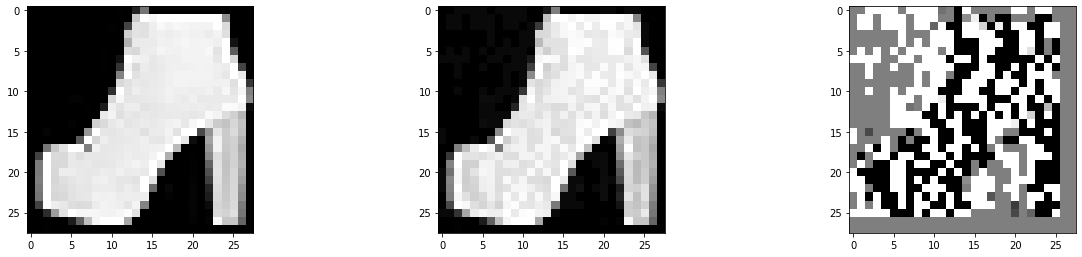

(2, 28, 28, 1) (100, 28, 28, 1)
['Ankle boot', 'Sandal']
Confidence benign: 0.999987006187439, adversarial: 0.39465391635894775


In [199]:
id = 44

plt.rcParams["figure.figsize"] = (20,10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
benign = train_images[id]
ax = fig.add_subplot(2,3, 1)
plt.imshow(benign.reshape((28,28)),cmap='gray');


adversarial = x_train_adv_images[id]
ax = fig.add_subplot(2,3, 2)
plt.imshow(adversarial.reshape((28,28)),cmap='gray');



perturb = adversarial - benign
ax = fig.add_subplot(2,3, 3)
plt.imshow(perturb.reshape((28,28)),cmap='gray');


plt.show()

probas = np.array([benign,adversarial])
print(probas.shape,x_images.shape)

y_prob = model_cnn.predict(probas)
y_classes = y_prob.argmax(axis=-1)
print(list(map(lambda x:class_names[x], y_classes)))
print(f"Confidence benign: {max(y_prob[0])}, adversarial: {max(y_prob[1])}")

   # ax.text(0.5, 0.5, str((2, 3, i)),
    #       fontsize=18, ha='center')

# Confidence comparison between adversarial and benign pictures





(983, 28, 28, 1)


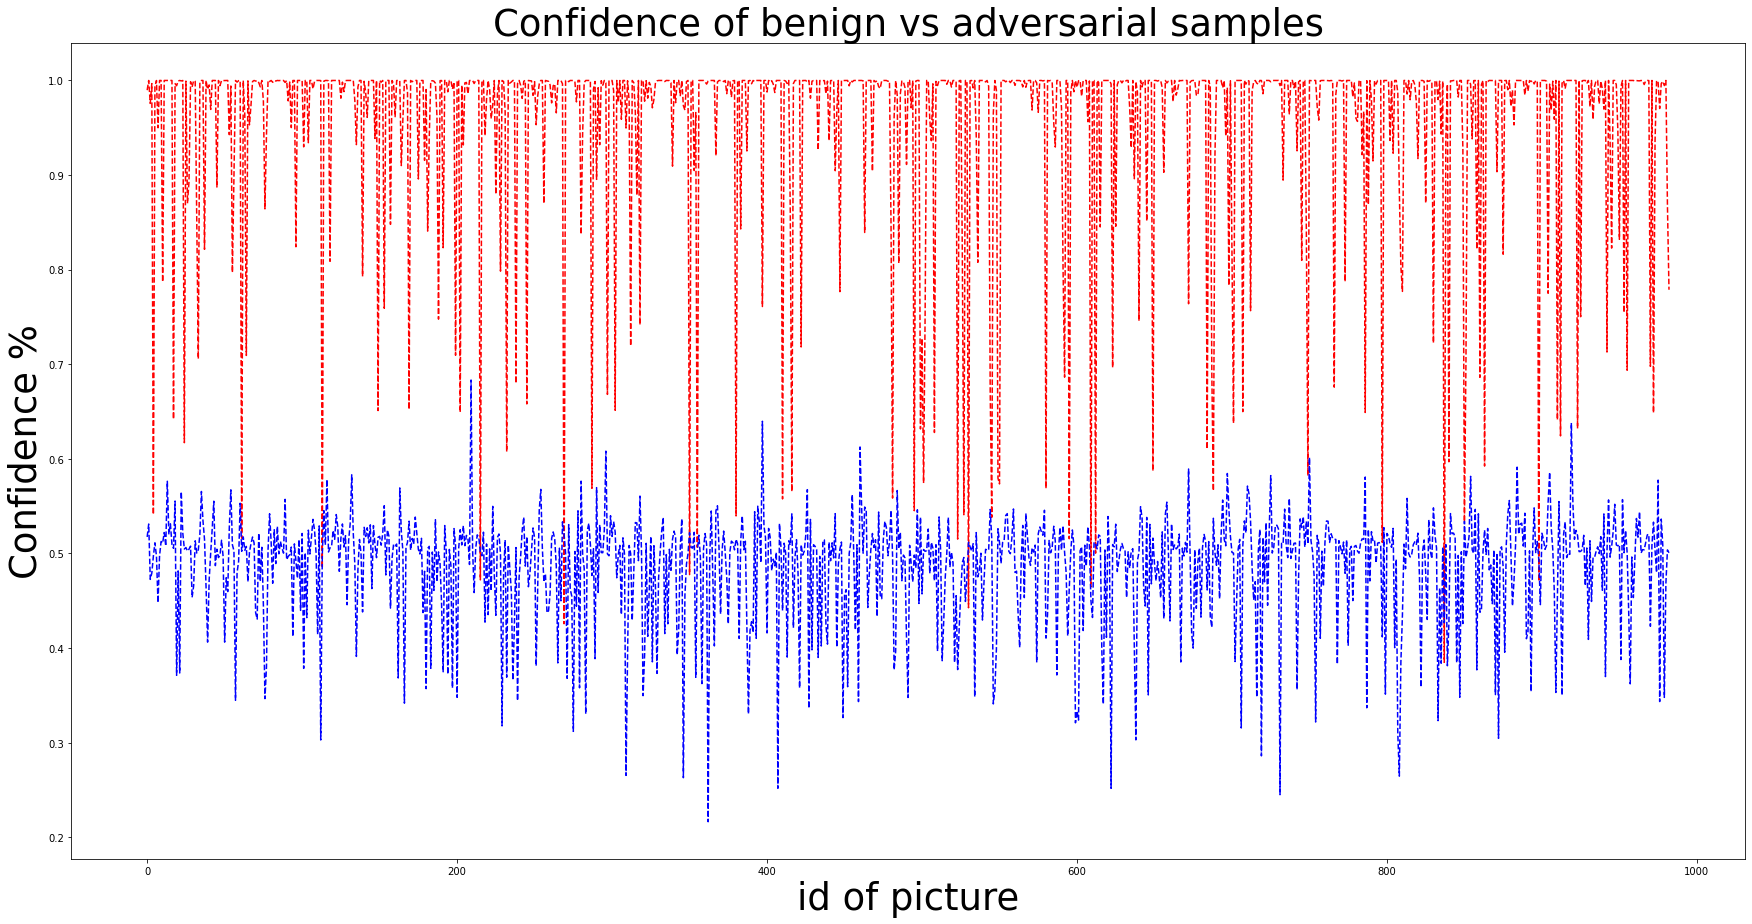

In [190]:
bcons = []
acons = []
print(x_train_adv_images.shape)
Num = len(x_train_adv_images)
for id in range(Num):
  benign = train_images[id]
  adversarial = x_train_adv_images[id]
  probas = np.array([benign,adversarial])
  y_prob = model_cnn.predict(probas)
  benign_conf = max(y_prob[0])
  adversarial_conf = max(y_prob[1])
  bcons.append(benign_conf)
  acons.append(adversarial_conf)
 # plt.imshow(benign.reshape((28,28)),cmap='gray')
 # plt.show()
plt.rcParams["figure.figsize"] = (30,15)
plt.plot([i for i in range(Num)], bcons,'--r')
plt.plot([i for i in range(Num)], acons,'--b')
plt.title('Confidence of benign vs adversarial samples',fontsize=37)
plt.ylabel('Confidence %',fontsize=37)
plt.xlabel('id of picture',fontsize=37)

plt.show()
   # ax.text(0.5, 0.5, str((2, 3, i)),
    #       fontsize=18, ha='center')

In [191]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Lets introduce adversarial class to see if the model can detect adversarial inputs

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot','Adversarial']
train_images = train_images/255.0
test_images = test_images/255.0
train_images = train_images.reshape((len(train_images),28,28,1))

train_images = np.concatenate((train_images,x_train_adv_images))
train_labels = np.concatenate((train_labels,[10] * len(x_train_labels) ))


In [213]:

model_cnn = keras.Sequential([
            
                            tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(28,28,1)),
                            tf.keras.layers.MaxPool2D((2,2)),
                            tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
                            tf.keras.layers.MaxPool2D((2,2)),

                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100,activation='relu'),
                            tf.keras.layers.Dense(100,activation='relu'),
                            tf.keras.layers.Dense(11,activation='softmax',name='prediction_layer')
            ])
            
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 10)        910       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 250)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_33 (Dense)             (None, 100)             

In [214]:

train_images = train_images#.reshape((len(train_images),28,28,1))
print(train_images.shape)
model_cnn.fit(train_images, train_labels,epochs=20)

(65957, 28, 28, 1)
Train on 65957 samples
Epoch 1/20
65957/65957 [==============================] - 6s 88us/sample - loss: 0.7723 - acc: 0.7279
Epoch 2/20
65957/65957 [==============================] - 6s 85us/sample - loss: 0.5028 - acc: 0.8258
Epoch 3/20
65957/65957 [==============================] - 6s 85us/sample - loss: 0.4041 - acc: 0.8589
Epoch 4/20
65957/65957 [==============================] - 6s 85us/sample - loss: 0.3593 - acc: 0.8731
Epoch 5/20
65957/65957 [==============================] - 6s 85us/sample - loss: 0.3319 - acc: 0.8825
Epoch 6/20
65957/65957 [==============================] - 6s 85us/sample - loss: 0.3102 - acc: 0.8891
Epoch 7/20
65957/65957 [==============================] - 6s 87us/sample - loss: 0.2916 - acc: 0.8964
Epoch 8/20
65957/65957 [==============================] - 6s 89us/sample - loss: 0.2787 - acc: 0.8992
Epoch 9/20
65957/65957 [==============================] - 6s 85us/sample - loss: 0.2675 - acc: 0.9048
Epoch 10/20
65957/65957 [===============

In [215]:
fmodel = foolbox.models.TensorFlowModel.from_keras(model_cnn, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)


x_images = train_images[0:6000, :]
x_images=x_images.reshape((len(x_images), 28, 28,1))
print(x_images[0].shape, x_images[33].shape)

(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = \
generate_adversarial_data(original_images = x_images, predictions = model_cnn.predict(x_images), attack_fn = attack_fn)

(28, 28, 1) (28, 28, 1)


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


(5987, 28, 28, 1)


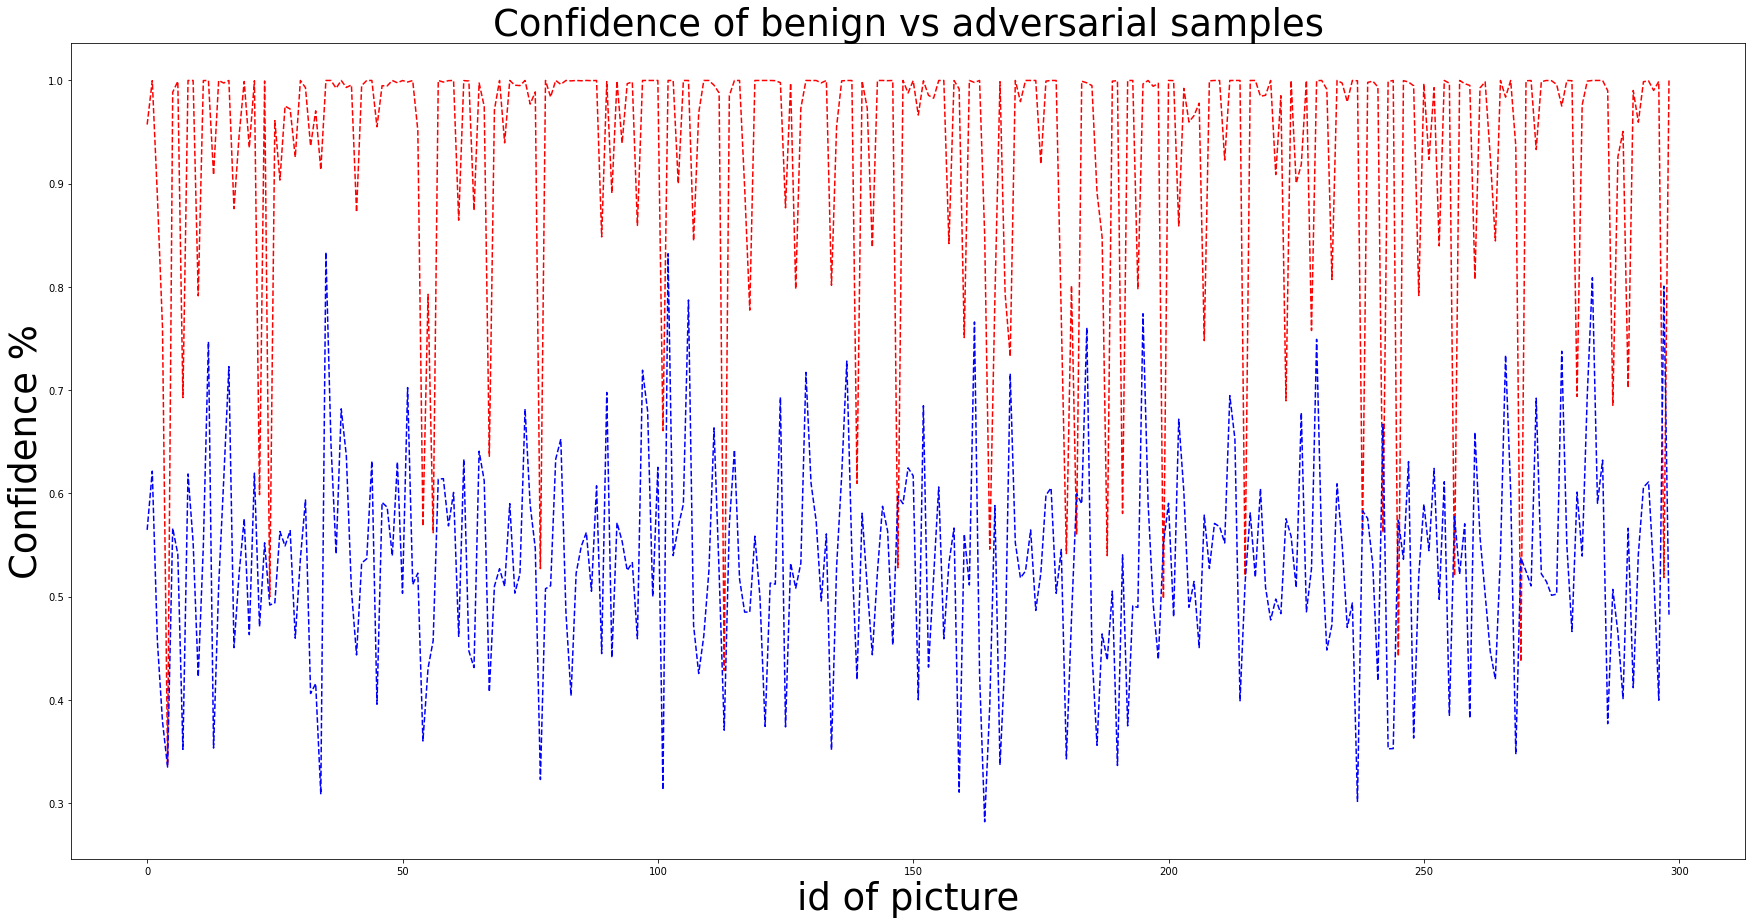

In [219]:
bcons = []
acons = []
print(x_train_adv_images.shape)
Num = len(x_train_adv_images)//20
for id in range(Num):
  benign = train_images[id]
  adversarial = x_train_adv_images[id]
  probas = np.array([benign,adversarial])
  y_prob = model_cnn.predict(probas)
  benign_conf = max(y_prob[0])
  adversarial_conf = max(y_prob[1])
  bcons.append(benign_conf)
  acons.append(adversarial_conf)
 # plt.imshow(benign.reshape((28,28)),cmap='gray')
 # plt.show()
plt.rcParams["figure.figsize"] = (30,15)
plt.plot([i for i in range(Num)], bcons,'--r')
plt.plot([i for i in range(Num)], acons,'--b')
plt.title('Confidence of benign vs adversarial samples',fontsize=37)
plt.ylabel('Confidence %',fontsize=37)
plt.xlabel('id of picture',fontsize=37)

plt.show()
   # ax.text(0.5, 0.5, str((2, 3, i)),
    #       fontsize=18, ha='center')

# That was a bad idea